In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
from dynchro.tl import skip_dtw, skip_traceback

In [3]:
from utils import plot_iroot, comp_kde, kdeplot, kdeplot2, compare, get_kde_eval, norm

In [4]:
import random

random.seed(34)
np.random.seed(34)

In [5]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [6]:
d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

### get counts and sort

In [7]:
def get_sorted_lineage(d, pseudotime_col, lineage_col):
    lineage = d[d.obs[lineage_col] == "TRUE"]
    sorting = np.argsort(lineage.obs[pseudotime_col])
    sorted_lin = lineage[sorting, :]
    return sorted_lin

In [8]:
d1_linC = get_sorted_lineage(d1, "orig_linC_pseudotime", "linC")
d1_linD = get_sorted_lineage(d1, "orig_linD_pseudotime", "linD")
d2_linC = get_sorted_lineage(d2, "orig_linC_pseudotime", "linC")
d2_linD = get_sorted_lineage(d2, "orig_linD_pseudotime", "linD")

In [9]:
def run_dtw(counts1, counts2):
    """
    Run DTW on two datasets
    """
    total, cost, distances = skip_dtw(counts1, counts2)
    path = skip_traceback(distances)

    sns.heatmap(cost, cmap="crest")
    plt.figure()
    sns.heatmap(distances[1:, 1:], cmap="crest")
    sns.lineplot(x=path[0], y=path[1], color="red", linewidth=1)
    plt.title(f"DTW, total cost: {total}")
    plt.show()

    return {"total distance": total, "cost": cost, "distances": distances, "path": path}

    

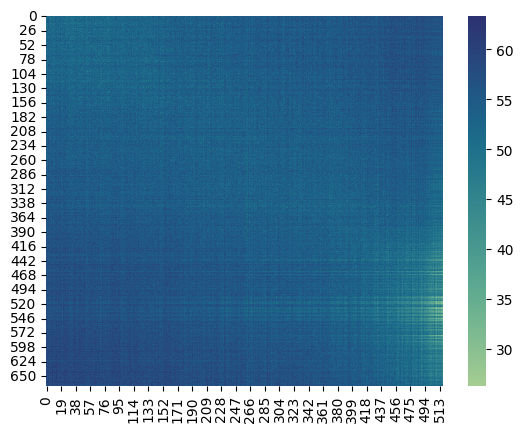

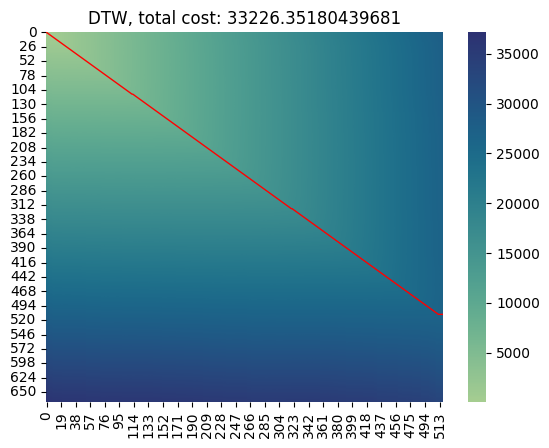

In [10]:
dtw_resultcc = run_dtw(d1_linC.X.toarray(), d2_linC.X.toarray())

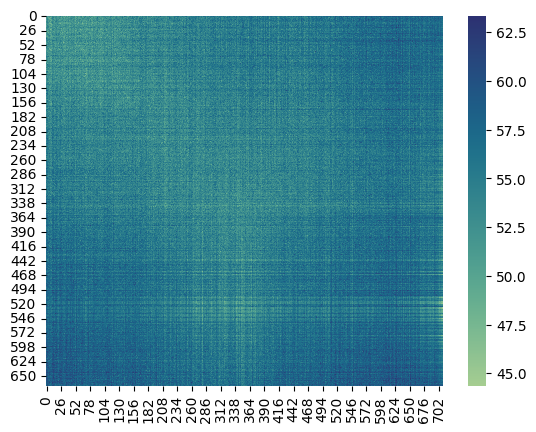

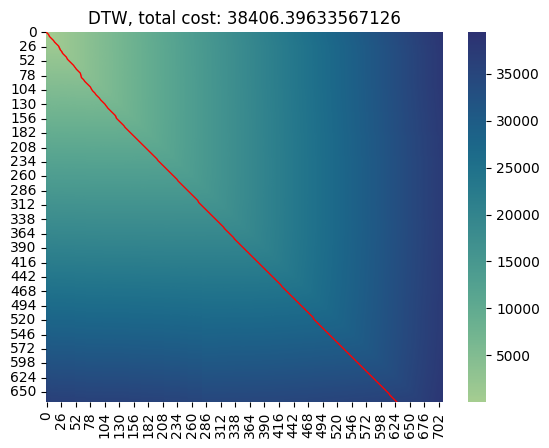

In [11]:
dtw_resultcd = run_dtw(d1_linC.X.toarray(), d2_linD.X.toarray())

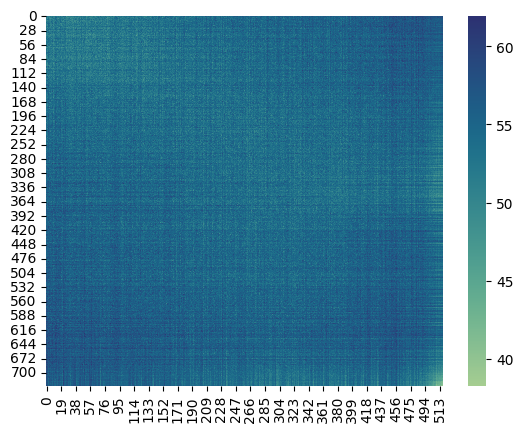

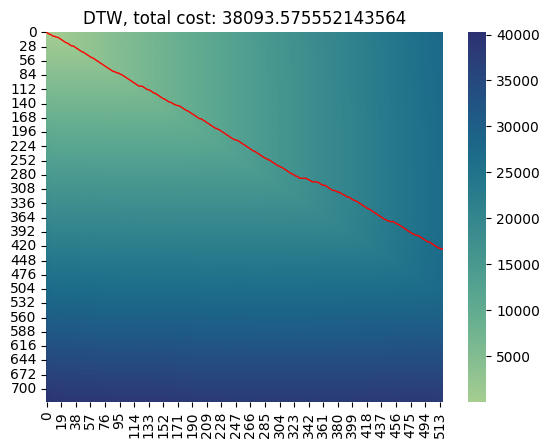

In [12]:
dtw_resultdc = run_dtw(d1_linD.X.toarray(), d2_linC.X.toarray())

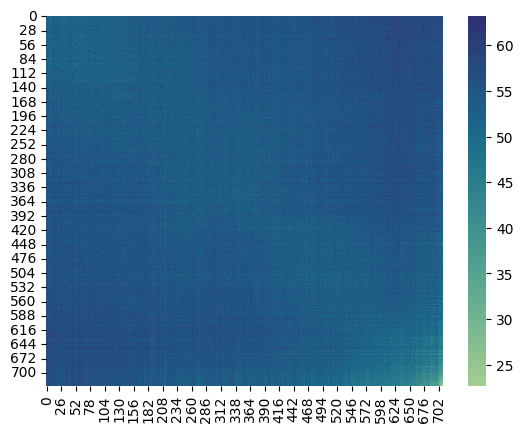

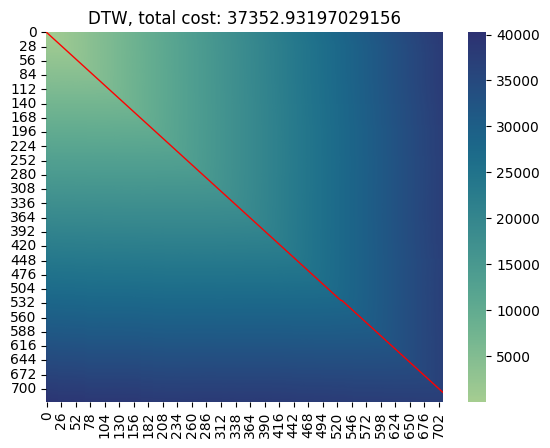

In [13]:
dtw_resultdd = run_dtw(d1_linD.X.toarray(), d2_linD.X.toarray())

In [14]:
dtw_resultcc, dtw_resultdd

({'total distance': np.float64(33226.35180439681),
  'cost': array([[54.38082099, 52.82459826, 51.4831011 , ..., 57.70977958,
          57.71867882, 58.53413254],
         [51.64099942, 50.45483394, 51.09850796, ..., 57.50758401,
          56.34383081, 57.63243494],
         [51.74695742, 50.15077959, 51.91072737, ..., 57.8857189 ,
          57.05162195, 58.2439569 ],
         ...,
         [57.49982003, 56.5421904 , 60.2971371 , ..., 49.35777743,
          50.69361708, 49.52789672],
         [59.26345471, 58.65159492, 60.81121389, ..., 48.26801598,
          49.77199155, 49.08028603],
         [57.84763336, 57.51804887, 60.45217169, ..., 49.65487364,
          52.76461501, 51.32632855]], shape=(668, 518)),
  'distances': array([[    0.        ,            inf,            inf, ...,
                     inf,            inf,            inf],
         [           inf,    54.38082099,   107.20541926, ...,
          28249.0197861 , 28306.73846493, 28365.27259747],
         [           inf, 

In [15]:
def warp_pseudotime(cells1, cells2, path1, path2, pseudot1, pseudot2, pseudocells=False):
    changed_pt1 = {}
    changed_pt2 = {}
    for p1, p2 in zip(path1, path2):
        if pseudocells:
            pt1 = pseudot1[p1]
            pt2 = pseudot2[p2]
            # eeek iffy if a multiple pseudocells have the same pseudotime
            changed_pt1 = add_to_dict(changed_pt1, pt1, pt2)
            changed_pt2 = add_to_dict(changed_pt2, pt2, pt1)
        else:
            pt1 = pseudot1.iloc[p1]
            pt2 = pseudot2.iloc[p2]

            changed_pt1 = add_to_dict(changed_pt1, cells1.obs.iloc[p1].name, pt2)
            changed_pt2 = add_to_dict(changed_pt2, cells2.obs.iloc[p2].name, pt1)

    index1 = list(changed_pt1.keys())
    index2 = list(changed_pt2.keys())
    cpt1 = [sum(x) / len(x) for x in changed_pt1.values()]
    cpt2 = [sum(x) / len(x) for x in changed_pt2.values()]

    return index1, cpt1, index2, cpt2


def add_to_dict(d, key, value):
    if key in d:
        d[key].append(value)
        # nr, cur_avg = d[key]
        # cur_avg_update = (cur_avg + value) / (nr + 1)
        # d[key] = (nr+1, cur_avg_update)
    else:
        d[key] = [value]
    return d


# add warped pseudotime to lineage
def add_warped_pseudotime(lineage, new_index, warped_pt, label, pseudocells=False):
    if pseudocells:
        # TODO sort or sth? Or keep the pseudotime as a pandas series/dataframe in .uns?
        lineage.uns[label + "_warped_pseudotime"] = pd.Series(warped_pt, index=new_index)
    else:
        # lineage.obs.iloc[new_index, label + "_warped_pseudotime"] = warped_pt
        lineage.obs[f"{label}_warped_pseudotime"] = pd.NA
        lineage.obs.update(pd.DataFrame({f"{label}_warped_pseudotime": warped_pt}, index=new_index))
        lineage.obs[f"{label}_warped_pseudotime"] = pd.to_numeric(lineage.obs[f"{label}_warped_pseudotime"])

    return lineage

In [16]:
# for each cell
# find which cell it corresponds to according to the path
# find what the pseudotime of those corresponding cells is
# average the pseudotimes of the corresponding cells
# assign this to the original cell

cells1 = d1_linC
cells2 = d2_linC

path1 = dtw_resultcc["path"][0]
path2 = dtw_resultcc["path"][1]

from collections import defaultdict
corresponding_cells = defaultdict(list)
corr1 = defaultdict(list)
corr2 = defaultdict(list)

for index1, index2 in zip(path1[1:], path2[1:]): # index is cell in cells2, value is cell in cells1
    corr1[index1].append(d2_linC.obs.orig_linC_pseudotime.iloc[index2 - 1])
    corr2[index2].append(d1_linC.obs.orig_linC_pseudotime.iloc[index1 - 1])

for key, value in corr1.items():
    corr1[key] = sum(value) / len(value)
for key, value in corr2.items():
    corr2[key] = sum(value) / len(value)

d1_linC.obs["warped_pseudotime"] = list(corr1.values())
d2_linC.obs["warped_pseudotime"] = list(corr2.values())


/tmp/ipykernel_70665/1357259627.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linC.obs["warped_pseudotime"] = list(corr1.values())
/tmp/ipykernel_70665/1357259627.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linC.obs["warped_pseudotime"] = list(corr2.values())


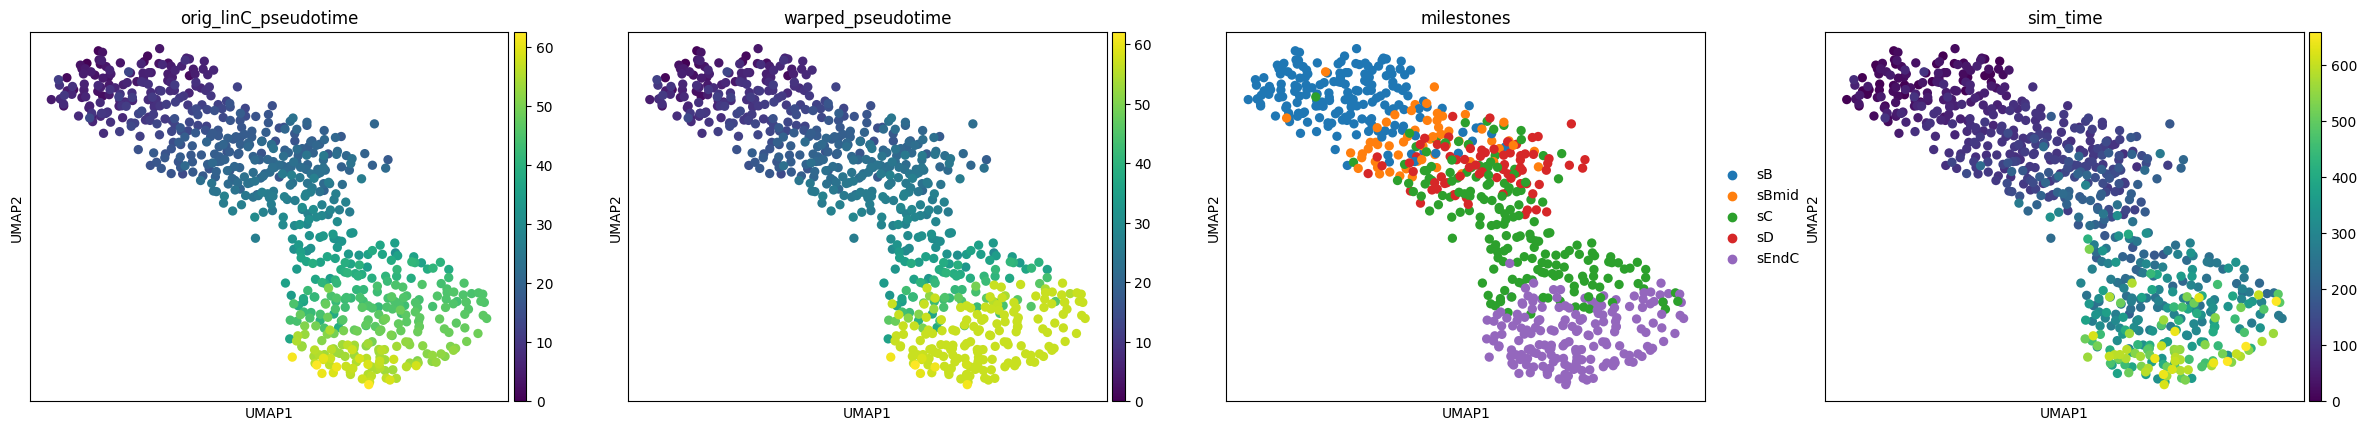

In [17]:
sc.pl.umap(d1_linC, color=["orig_linC_pseudotime", "warped_pseudotime", "milestones", "sim_time"])

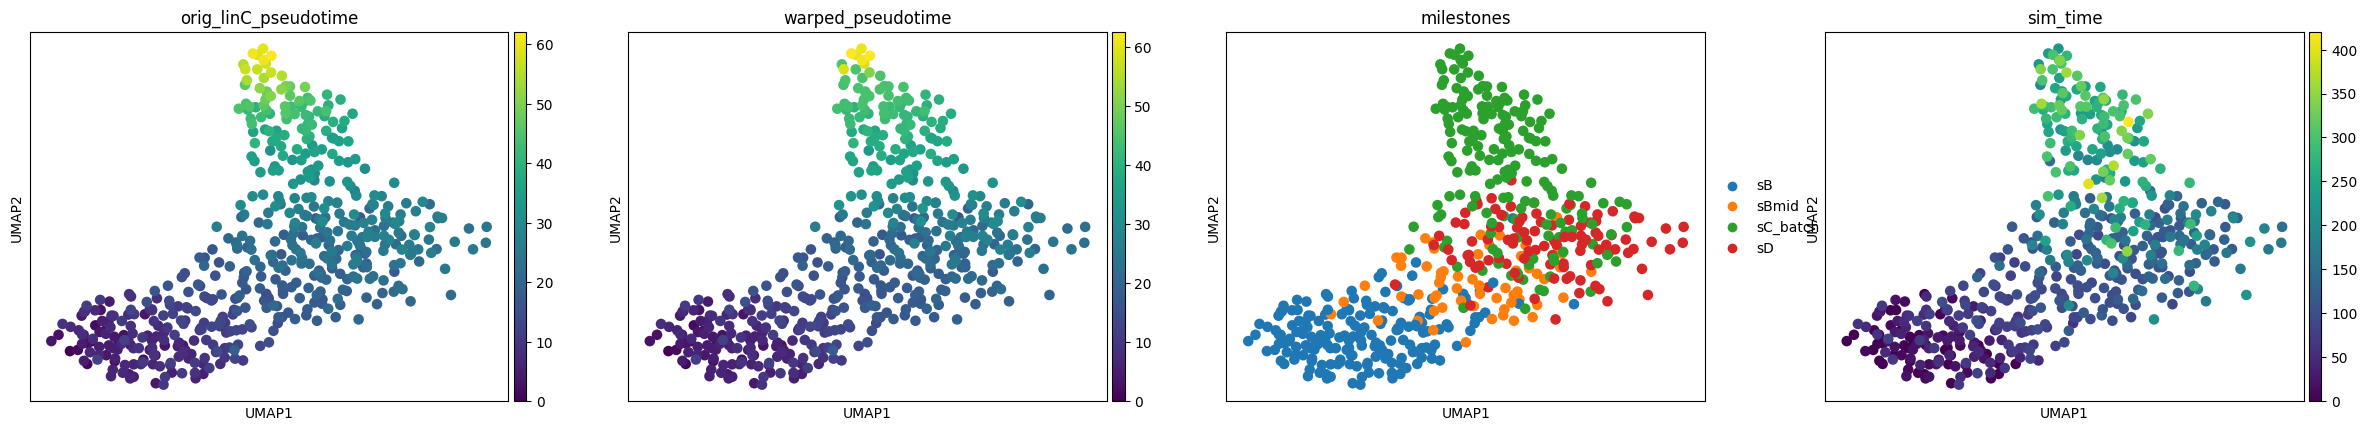

In [18]:
sc.pl.umap(d2_linC, color=["orig_linC_pseudotime", "warped_pseudotime", "milestones", "sim_time"])

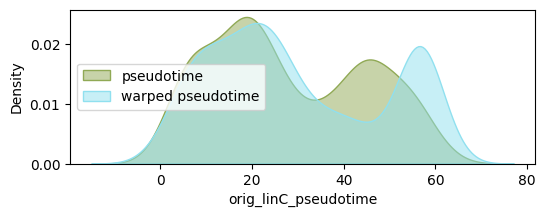

In [19]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    sns.kdeplot(d1_linC.obs["orig_linC_pseudotime"], label="pseudotime", fill = True, alpha=0.5, color="#90a955")
    sns.kdeplot(d1_linC.obs["warped_pseudotime"], label="warped pseudotime", fill = True, alpha=0.5, color="#90e0ef")
    plt.legend()

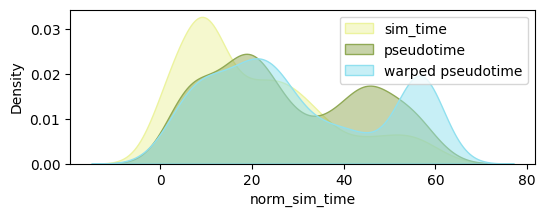

In [20]:
d1_linC.obs["norm_sim_time"] = (d1_linC.obs["sim_time"] - min(d1_linC.obs["sim_time"])) / (max(d1_linC.obs["sim_time"]) - min(d1_linC.obs["sim_time"])) * max(d1_linC.obs["orig_linC_pseudotime"])

with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    sns.kdeplot(d1_linC.obs["norm_sim_time"], label="sim_time", fill = True, alpha=0.5, color="#ecf39e")
    sns.kdeplot(d1_linC.obs["orig_linC_pseudotime"], label="pseudotime", fill = True, alpha=0.5, color="#90a955")
    sns.kdeplot(d1_linC.obs["warped_pseudotime"], label="warped pseudotime", fill = True, alpha=0.5, color="#90e0ef")

    plt.legend()

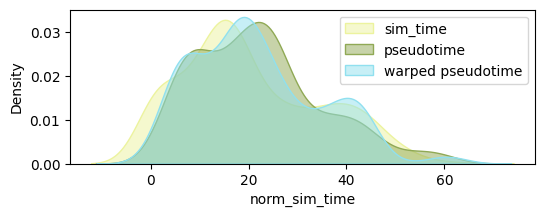

In [21]:
d2_linC.obs["norm_sim_time"] = (d2_linC.obs["sim_time"] - min(d2_linC.obs["sim_time"])) / (max(d2_linC.obs["sim_time"]) - min(d2_linC.obs["sim_time"])) * max(d2_linC.obs["orig_linC_pseudotime"])

with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    sns.kdeplot(d2_linC.obs["norm_sim_time"], label="sim_time", fill = True, alpha=0.5, color="#ecf39e")
    sns.kdeplot(d2_linC.obs["orig_linC_pseudotime"], label="pseudotime", fill = True, alpha=0.5, color="#90a955")
    sns.kdeplot(d2_linC.obs["warped_pseudotime"], label="warped pseudotime", fill = True, alpha=0.5, color="#90e0ef")

    plt.legend()

# Metrics

In [22]:
linC = pd.concat([d1_linC.obs["orig_linC_pseudotime"], d2_linC.obs["orig_linC_pseudotime"]])
linD = pd.concat([d1_linD.obs["orig_linD_pseudotime"], d2_linD.obs["orig_linD_pseudotime"]])

linC_warped = pd.concat([d1_linC.obs["warped_pseudotime"], d2_linC.obs["warped_pseudotime"]])
# linD_warped = pd.concat([d1_linD.obs["warped_pseudotime"], d2_linD.obs["warped_pseudotime"]])

cbx, cby, cbkde = get_kde_eval(norm(linC), bandwith = 0.1)
cax, cay, cakde = get_kde_eval(norm(linC_warped), bandwith = 0.1)

In [35]:
startC = min(d1_linC[d1_linC.obs["milestones"] == "sC"].obs["orig_linC_pseudotime"])
startEndC = min(d1_linC[d1_linC.obs["milestones"] == "sEndC"].obs["orig_linC_pseudotime"])
linmin = min(linC)
linmax = max(linC)

startC_normalized = (startC - linmin) / (linmax - linmin)
startEndC_normalized = (startEndC - linmin) / (linmax - linmin)

startC_normalized, startEndC_normalized

(0.18798988170404404, 0.5908188837727303)

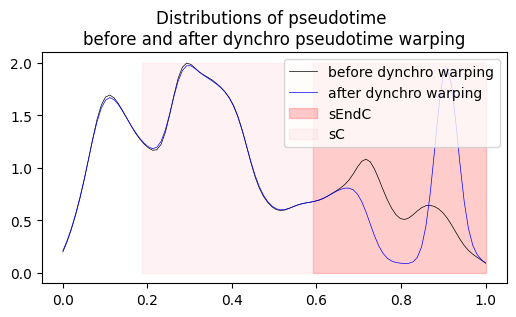

In [41]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(cbx, cby, color="black", lw=0.5, label="before dynchro warping")
ax.plot(cax, cay, color="blue", lw=0.5, label="after dynchro warping")

ax.fill_between([startEndC_normalized, 1], 0, 2, color="red", alpha=0.2, label="sEndC")
ax.fill_between([startC_normalized, startEndC_normalized], 0, 2, color="pink", alpha=0.2, label="sC")

plt.title("Distributions of pseudotime \nbefore and after dynchro pseudotime warping")
plt.legend()
plt.show()

In [24]:
c_wasserstein = scipy.stats.wasserstein_distance(cbx, cax, cby, cay)
print(f"Wasserstein distance before vs after C: {c_wasserstein}")

Wasserstein distance before vs after C: 0.012133055901246317


In [32]:
# get sC
sC = d1_linC[d1_linC.obs["milestones"] == "sC"]
min(sC.obs.orig_linC_pseudotime)

11.758782430845692

In [34]:
sCEnd = d1_linC[d1_linC.obs["milestones"] == "sEndC"]
min(sCEnd.obs.orig_linC_pseudotime)

36.95576936026761

In [33]:
min(linC), max(linC)

(0.0, 62.55008154831312)

In [28]:
d1_linC.obs.milestones

cell952       sB
cell530       sB
cell600       sB
cell79        sB
cell746       sB
           ...  
cell395    sEndC
cell737    sEndC
cell543    sEndC
cell469    sEndC
cell730    sEndC
Name: milestones, Length: 668, dtype: category
Categories (5, object): ['sB', 'sBmid', 'sC', 'sD', 'sEndC']

In [ ]:
# dynchro preserves pseudotime
before_pseudotime = pd.concat([norm(d1_linC.obs["orig_linC_pseudotime"]), norm(d2_linC.obs["orig_linC_pseudotime"])])
after_pseudotime = pd.concat([norm(d1_linC.obs["warped_pseudotime"]), norm(d2_linC.obs["warped_pseudotime"])])

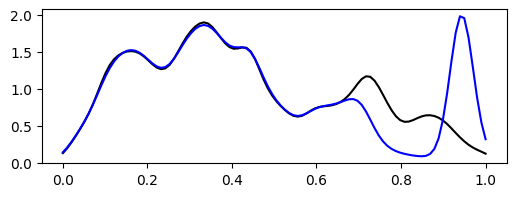

In [37]:
beforex, beforey, beforekde = get_kde_eval(before_pseudotime, bandwith=0.1)
afterx, aftery, afterkde = get_kde_eval(after_pseudotime, bandwith=0.1)

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(beforex, beforey, label="before", color="black")
ax.plot(afterx, aftery, label="after", color="blue")

In [51]:
m = scipy.stats.wasserstein_distance(beforex, afterx, beforey, aftery)
print(f"Wasserstein distance control vs premature stop: {m}")

Wasserstein distance control vs premature stop: 0.016234765010551915


In [39]:
before_c1 = norm(cells1.obs["pseudotime"])
before_c2 = norm(cells2.obs["pseudotime"])
after_c1 = norm(cells1.obs["warped_pseudotime"])
after_c2 = norm(cells2.obs["warped_pseudotime"])

In [40]:
before_c1_x, before_c1_y, before_c1_kde = get_kde_eval(before_c1, bandwith=0.1)
before_c2_x, before_c2_y, before_c2_kde = get_kde_eval(before_c2, bandwith=0.1)
after_c1_x, after_c1_y, after_c1_kde = get_kde_eval(after_c1, bandwith=0.1)
after_c2_x, after_c2_y, after_c2_kde = get_kde_eval(after_c2, bandwith=0.1)

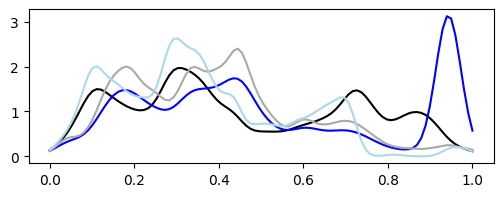

In [41]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(before_c1_x, before_c1_y, label="before c1", color="black")
ax.plot(after_c1_x, after_c1_y, label="after c1", color="blue")
ax.plot(before_c2_x, before_c2_y, label="before c2", color="darkgrey")
ax.plot(after_c2_x, after_c2_y, label="after c2", color="lightblue")

In [42]:
np.save("data/before_c1_x", before_c1_x)
np.save("data/before_c1_y", before_c1_y)
np.save("data/before_c2_x", before_c2_x)
np.save("data/before_c2_y", before_c2_y)
np.save("data/before_pseudotime_x", beforex)
np.save("data/before_pseudotime_y", beforey)
np.save("data/before_pseudotime", before_pseudotime)


In [43]:
# cells 1 is to c
# cells 2 is to d
gt1_simtime = norm(cells1.obs["sim_time"])
gt2_simtime = norm(cells2.obs["sim_time"])
gt1_pseudotime = norm(cells1.obs["pseudotime"])
gt2_pseudotime = norm(cells2.obs["pseudotime"])
gt1_warped_pseudotime = norm(cells1.obs["warped_pseudotime"])
gt2_warped_pseudotime = norm(cells2.obs["warped_pseudotime"])

In [44]:
import scipy.stats

bandwidth = 0.1

# kde from gt1_simtime and gt1_warped_pseudotime
kde_gt1_simtime = scipy.stats.gaussian_kde(gt1_simtime, bw_method=bandwidth)
kde_gt1_pseudotime = scipy.stats.gaussian_kde(gt1_pseudotime, bw_method=bandwidth)

# interpolation points
x_eval = np.linspace(0, 1, 100)
# evaluate kdes
kde_gt1_simtime_eval = kde_gt1_simtime(x_eval)
kde_gt1_pseudotime_eval = kde_gt1_pseudotime(x_eval)

Calculate the differences between the distributions

In [47]:
gt1_simtime

cell952    0.030485
cell530    0.000000
cell600    0.000000
cell79     0.000000
cell685    0.000000
             ...   
cell395    0.576933
cell737    0.592112
cell543    0.850157
cell469    0.941105
cell730    0.576933
Name: sim_time, Length: 668, dtype: float64

In [49]:
# uvalues, vvalues = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
# uweights, vweights are the evaluations of the kde values on the interpolation points

m = scipy.stats.wasserstein_distance(x_eval, x_eval, kde_gt1_simtime_eval, kde_gt1_pseudotime_eval)
print(f"Wasserstein distance between gt1_simtime and gt1_warped_pseudotime: {m}")

Wasserstein distance between gt1_simtime and gt1_warped_pseudotime: 0.12437369573824174


In [45]:
cells2.obs.milestones

cell700          sB
cell989          sB
cell393          sB
cell324          sB
cell847          sB
             ...   
cell952    sC_batch
cell351    sC_batch
cell797    sC_batch
cell603    sC_batch
cell942    sC_batch
Name: milestones, Length: 507, dtype: category
Categories (4, object): ['sB', 'sBmid', 'sC_batch', 'sD']

In [ ]:
def get_milestone_normalised(cells1, cells2, milestone1, milestone2, maxv, time = "pseudotime"):
    milestone_cells = pd.concat([cells1[cells1.obs["milestones"] == milestone1].obs[time], cells2[cells2.obs["milestones"] == milestone2].obs[time]])
    localmax = max(milestone_cells) / maxv
    print(maxv, localmax, max(milestone_cells))
    return pd.concat([norm(milestone_cells, max_value=localmax)])
    

In [55]:
maxall = max(cells1.obs["pseudotime"].max(), cells2.obs["pseudotime"].max())
mbcells = get_milestone_normalised(cells1, cells2, "sB", "sB", maxall)
mccells = get_milestone_normalised(cells1, cells2, "sC", "sC_batch", maxall)
mdcells = get_milestone_normalised(cells1, cells2, "sD", "sD", maxall)
mendccells = get_milestone_normalised(cells1, cells2, "sEndC", "sEndC", maxall)
mbmidcells = get_milestone_normalised(cells1, cells2, "sBmid", "sBmid", maxall)

63.97165927516036 0.3503812447950897 22.414469608438033
63.97165927516036 1.0 63.97165927516036
63.97165927516036 0.5177519451966153 33.12145102716937
63.97165927516036 0.9951497200992941 63.66137882196325
63.97165927516036 0.3929129271236364 25.13529189875918


In [56]:
max_warped = max(cells1.obs["warped_pseudotime"].max(), cells2.obs["warped_pseudotime"].max())
mbcells_warped = get_milestone_normalised(cells1, cells2, "sB", "sB", max_warped, time = "warped_pseudotime")
mccells_warped = get_milestone_normalised(cells1, cells2, "sC", "sC_batch", max_warped, time = "warped_pseudotime")
mdcells_warped = get_milestone_normalised(cells1, cells2, "sD", "sD", max_warped, time = "warped_pseudotime")
mendccells_warped = get_milestone_normalised(cells1, cells2, "sEndC", "sEndC", max_warped, time = "warped_pseudotime")
mbmidcells_warped = get_milestone_normalised(cells1, cells2, "sBmid", "sBmid", max_warped, time = "warped_pseudotime")

63.97165927516036 0.3720879581028783 23.803084076147474
63.97165927516036 0.9949163720064498 63.6464511572753
63.97165927516036 0.4952241574935181 31.680311068003693
63.97165927516036 1.0 63.97165927516036
63.97165927516036 0.41209818080772054 26.36260441054493


In [48]:
# # select cells from milestone sA
# milestone_b_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sB"].obs.pseudotime, max_value = max(cells2[cells2.obs["milestones"] == "sB"].obs.pseudotime))])
# # milestone_mid_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sBmid"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sBmid"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sBmid"].obs.pseudotime, max_value = max(cells2[cells2.obs["milestones"] == "sBmid"].obs.pseudotime))])
# milestone_c_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sC"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sC"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sC_batch"].obs.pseudotime, max_value= max(cells2[cells2.obs["milestones"] == "sC_batch"].obs.pseudotime))])
# milestone_d_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sD"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sD"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sD"].obs.pseudotime, max_value= max(cells2[cells2.obs["milestones"] == "sD"].obs.pseudotime))])
# milestone_endc_cells = norm(cells1[cells1.obs["milestones"] == "sEndC"].obs.pseudotime, max_value= max(cells1[cells1.obs["milestones"] == "sEndC"].obs.pseudotime))
# lineagec_cells = pd.concat([milestone_c_cells, milestone_endc_cells])

In [49]:
# max(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime)

In [50]:
xb, yb, _ = get_kde_eval(mbcells, bandwith=0.1)
xm, ym, _ = get_kde_eval(mbmidcells, bandwith=0.1)
xc, yc, _ = get_kde_eval(mccells, bandwith=0.1)
xd, yd, _ = get_kde_eval(mdcells, bandwith=0.1)
xendc, yendc, _ = get_kde_eval(mendccells, bandwith=0.1)

In [57]:
xbw, ybw, _ = get_kde_eval(mbcells_warped, bandwith=0.1)
xmw, ymw, _ = get_kde_eval(mbmidcells_warped, bandwith=0.1)
xcw, ycw, _ = get_kde_eval(mccells_warped, bandwith=0.1)
xdw, ydw, _ = get_kde_eval(mdcells_warped, bandwith=0.1)
xendcw, yendcw, _ = get_kde_eval(mendccells_warped, bandwith=0.1)

In [51]:
max(mbcells), max(xb)

(0.3503812447950897, np.float64(1.0))

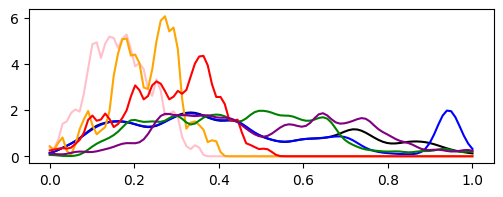

In [52]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(beforex, beforey, label="before", color="black")
ax.plot(afterx, aftery, label="after", color="blue")
ax.plot(xb, yb, label="milestone B", color="pink")
ax.plot(xm, ym, label="milestone Bmid", color="orange")
ax.plot(xc, yc, label="milestone C", color="green")
ax.plot(xd, yd, label="milestone D", color="red")
ax.plot(xendc, yendc, label="milestone EndC", color="purple")

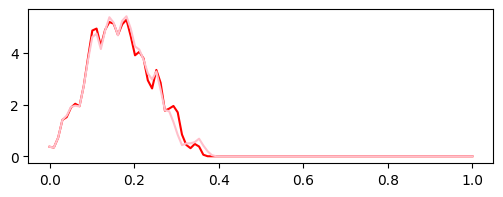

In [58]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xb, yb, label="milestone B", color="red")
ax.plot(xbw, ybw, label="milestone B warped", color="pink")

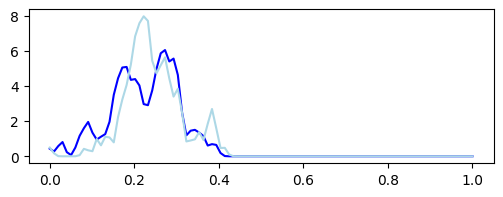

In [60]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xm, ym, label="milestone Bmid", color="blue")
ax.plot(xmw, ymw, label="milestone Bmid warped", color="lightblue")

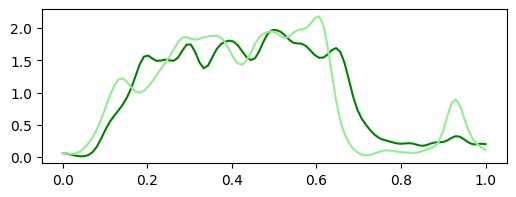

In [59]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xc, yc, label="milestone C", color="green")
ax.plot(xcw, ycw, label="milestone C warped", color="lightgreen")

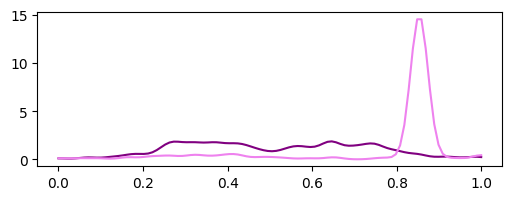

In [61]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xendc, yendc, label="milestone EndC", color="purple")
ax.plot(xendcw, yendcw, label="milestone EndC warped", color="violet")

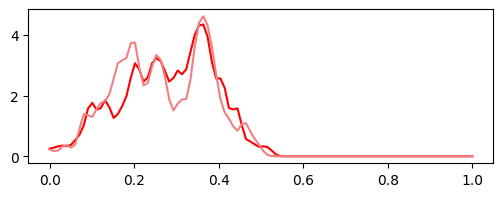

In [62]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xd, yd, label="milestone D", color="red")
ax.plot(xdw, ydw, label="milestone D warped", color="lightcoral")